In [14]:
# Change directory to the upper directory.
import os

analysis_dir_name = "analysis"

current_dir = os.path.split(os.getcwd())[1]
if current_dir == analysis_dir_name:
    os.chdir("..")

In [15]:
import ai.nn.data_set as ds
from ai.nn.neural_network import create_model, format_data_set, get_inputs_real_outputs
from ai.nn.evaluation import errors
from ai.helpers import data_set_file_path

%matplotlib notebook
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import random

In [16]:
seed = 42
num_subgrids_list = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]

subgrid_radius = 2
num_tiles_subgrids = ((subgrid_radius * 2) + 1) ** 2
num_rows_grid = 10
num_columns_grid = 10
num_bombs_grid = 10
num_masked_subgrids = 10

ds_no_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, False)
ds_bm_file_name = data_set_file_path(num_rows_grid, num_columns_grid, num_bombs_grid, subgrid_radius, True)
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

random.seed(seed)
np.random.seed(int(seed)) # Makes Keras deterministic.
tf.set_random_seed(seed) # Makes TensorFlow deterministic.

# Test set.
data_set_gen = ds.read_data_set(ds_no_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set = [next(data_set_gen) for i in range(5000)]

data_set_gen = ds.read_data_set(ds_bm_file_name)
for i in range(int(ds.SIZE / 2)): next(data_set_gen) # Skip the half of the data set.
test_set.extend([next(data_set_gen) for i in range(5000)])
print("Data set loaded.")

# Format the test set.
test_set = format_data_set(test_set, num_masked_subgrids)
print("Test set formatted.")

# Get the 'x' and 'y_true' vectors.
x_test, y_true_test = get_inputs_real_outputs(test_set)
print("Inputs and real outputs extracted.\n")

# Data set generators for the training set.
data_set_no_bm_gen = ds.read_data_set(ds_no_bm_file_name)
data_set_bm_gen = ds.read_data_set(ds_bm_file_name)
# 'bm' for means that the tile in the middle of the subgrids contains a bomb.

err_list = []
training_set = []
previous_num_subgrids = 0
for num_subgrids in num_subgrids_list:
    print("Number of subgrids: {}".format(num_subgrids))
    
    num_sugrids_to_add = num_subgrids - previous_num_subgrids
    num_no_bm_subgrids_to_add = int(num_sugrids_to_add / 2)
    num_no_bm_subgrids_to_add = int(num_sugrids_to_add / 2)
    
    # Load the data set.
    data_set = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids_to_add)]
    data_set.extend([next(data_set_bm_gen) for i in range(num_no_bm_subgrids_to_add)])
    """
    # Alternate the subgrids whose the middle tile contains a bomb and the subgrids whose
    # the middle tile does not contain a bomb.
    data_set = []
    data_set_no_bm = [next(data_set_no_bm_gen) for i in range(num_no_bm_subgrids_to_add)]
    data_set_bm = [next(data_set_bm_gen) for i in range(num_no_bm_subgrids_to_add)]
    for data_no_bm, data_bm in zip(data_set_no_bm, data_set_bm):
        data_set.append(data_no_bm)
        data_set.append(data_bm)
    """
    print("Data set loaded.")
    
     # Format the data set.
    data_set = format_data_set(data_set, num_masked_subgrids)
    print("Data set formatted.")
    
    # Add the data set to the training set.
    training_set.extend(data_set)
    
    # Get the 'x' and 'y_true' vectors.
    x_training, y_true_training = get_inputs_real_outputs(training_set)
    print("Inputs and real outputs extracted.")

    # Create the model.
    model = create_model(num_tiles_subgrids)
    
    # Train the model.
    model.fit(x_training, y_true_training, epochs=1, batch_size=10)
    print("Neural network trained.")
    
    # Prediction and errors.
    y_pred = model.predict(x_test)
    y_pred = [y_p[0] for y_p in y_pred]

    # Errors
    error_func = lambda y_t, y_p: abs(y_t - y_p)
    err = errors(y_true_test, y_pred, error_func)
    print("Errors computed.")

    err_list.append(err)
    
    previous_num_subgrids = num_subgrids
    
    print('')

Data set loaded.
Test set formatted.
Inputs and real outputs extracted.

Number of subgrids: 100
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
1000/1000 [==============================] - 1s 529us/step - loss: 0.2271 - mean_squared_error: 0.2271 - mean_absolute_error: 0.4573 - acc: 0.6210
Neural network trained.
Errors computed.

Number of subgrids: 500
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
5000/5000 [==============================] - 1s 234us/step - loss: 0.2133 - mean_squared_error: 0.2133 - mean_absolute_error: 0.4263 - acc: 0.6480
Neural network trained.
Errors computed.

Number of subgrids: 1000
Data set loaded.
Data set formatted.
Inputs and real outputs extracted.
Epoch 1/1
10000/10000 [==============================] - 2s 172us/step - loss: 0.2043 - mean_squared_error: 0.2043 - mean_absolute_error: 0.4064 - acc: 0.6597
Neural network trained.
Errors computed.

Number of subgrids: 5000
Data set loade

In [17]:
opacity = 1
color = '#FED487'
edge_color = 'black'
mean_color = 'orange'
percentile_25_color = 'limegreen'
median_color = 'red'
percentile_75_color = 'limegreen'
dot_color = 'black'

save_fig = True
plot_path = analysis_dir_name + "/plots/"
fig_format = 'png'
fig_dpi = 500

In [18]:
num_subgrids = []
errs = []
i = 0
for ns, err in zip(num_subgrids_list, err_list):
    num_subgrids.extend([i] * len(err))
    errs.extend(err)
    i+=1

#random.seed(42)

# Add a jitter.
jitter = 0.5
num_subgrids = [(ns + random.uniform(-jitter, jitter)) for ns in num_subgrids]

"""
# Add a second jitter.
jitter /= 2
num_subgrids = [(ns + random.uniform(-jitter, jitter)) for ns in num_subgrids]
"""

'\n# Add a second jitter.\njitter /= 2\nnum_subgrids = [(ns + random.uniform(-jitter, jitter)) for ns in num_subgrids]\n'

<IPython.core.display.Javascript object>


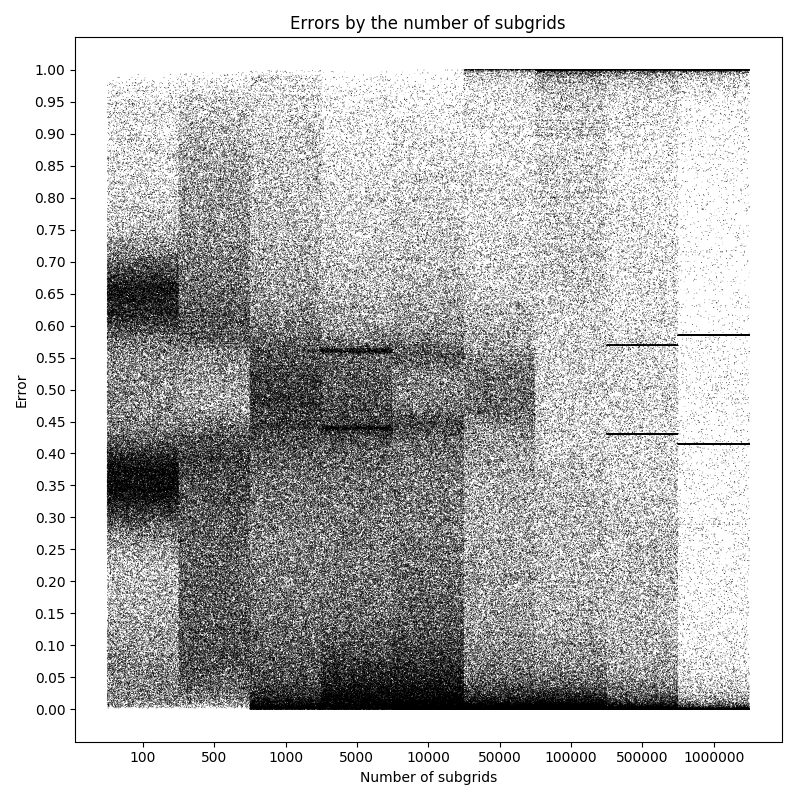

In [19]:
# Scatter plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
plt.scatter(num_subgrids, errs, s=np.arange(0.01, 0.41, 0.01), linewidths=0.01, c=dot_color)
plt.xticks(range(len(num_subgrids_list)), num_subgrids_list)
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the number of subgrids')
plt.xlabel('Number of subgrids')
plt.ylabel('Error')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_by_num_subgrids_scatter_plot.' + fig_format), format=fig_format, dpi=fig_dpi)

<IPython.core.display.Javascript object>


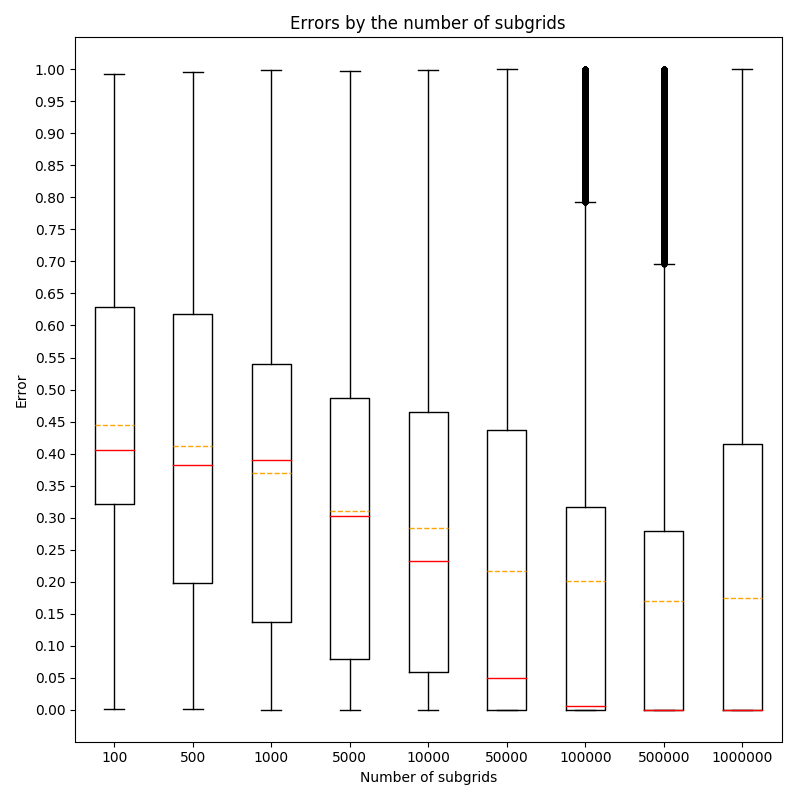

In [20]:
# Box plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
bplot = plt.boxplot(err_list, showmeans=True, meanline=True, sym='.')
plt.xticks(range(1, len(num_subgrids_list) + 1), num_subgrids_list)
plt.yticks(np.arange(0.0, 1.05, 0.05))
plt.title('Errors by the number of subgrids')
plt.xlabel('Number of subgrids')
plt.ylabel('Error')
plt.setp(bplot['means'], color=mean_color)
plt.setp(bplot['medians'], color=median_color)
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_by_num_subgrids_box_plot.' + fig_format), format=fig_format, dpi=fig_dpi)

In [21]:
means = []
percentiles_25 = []
percentiles_50 = []
percentiles_75 = []
for err in err_list:
    means.append(np.mean(err))
    percentiles_25.append(np.percentile(err, 25))
    percentiles_50.append(np.percentile(err, 50))
    percentiles_75.append(np.percentile(err, 75))

<IPython.core.display.Javascript object>


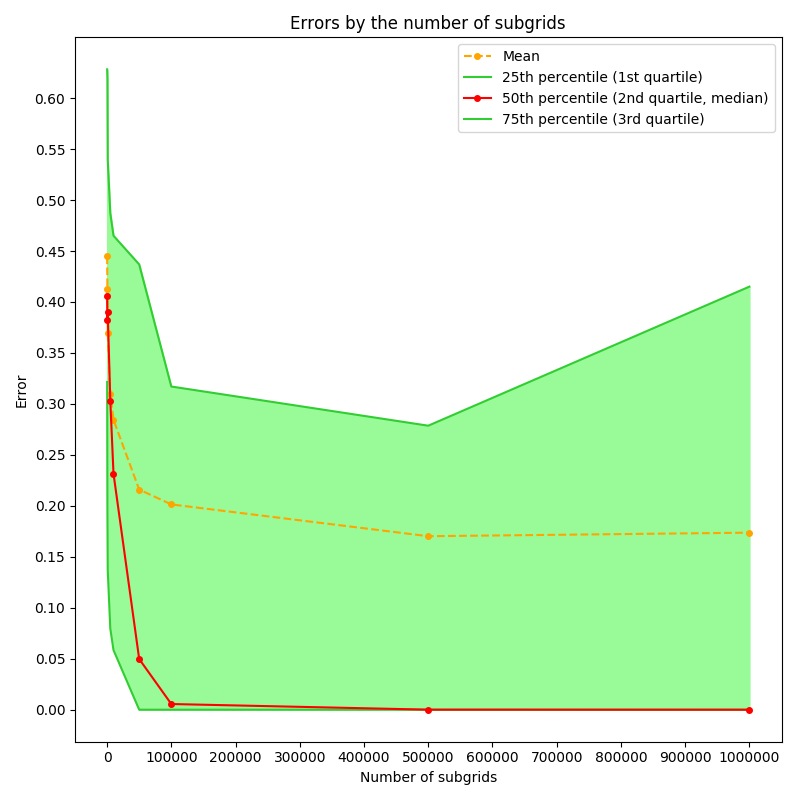

In [22]:
# Line plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
plt.plot(num_subgrids_list, means, color=mean_color, marker='o', linestyle='dashed', markersize=4)
plt.plot(num_subgrids_list, percentiles_25, color=percentile_25_color)
plt.plot(num_subgrids_list, percentiles_50, color=median_color, marker='o', markersize=4)
plt.plot(num_subgrids_list, percentiles_75, color=percentile_75_color)
plt.xticks(range(0, 1100000, 100000))
plt.yticks(np.arange(0.0, 0.65, 0.05))
plt.title('Errors by the number of subgrids')
plt.xlabel('Number of subgrids')
plt.ylabel('Error')
plt.legend(['Mean', '25th percentile (1st quartile)', '50th percentile (2nd quartile, median)', '75th percentile (3rd quartile)'], loc='upper right')
plt.fill_between(num_subgrids_list, percentiles_25, percentiles_75, color='palegreen')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_by_num_subgrids_line_plot.' + fig_format), format=fig_format, dpi=fig_dpi)

<IPython.core.display.Javascript object>


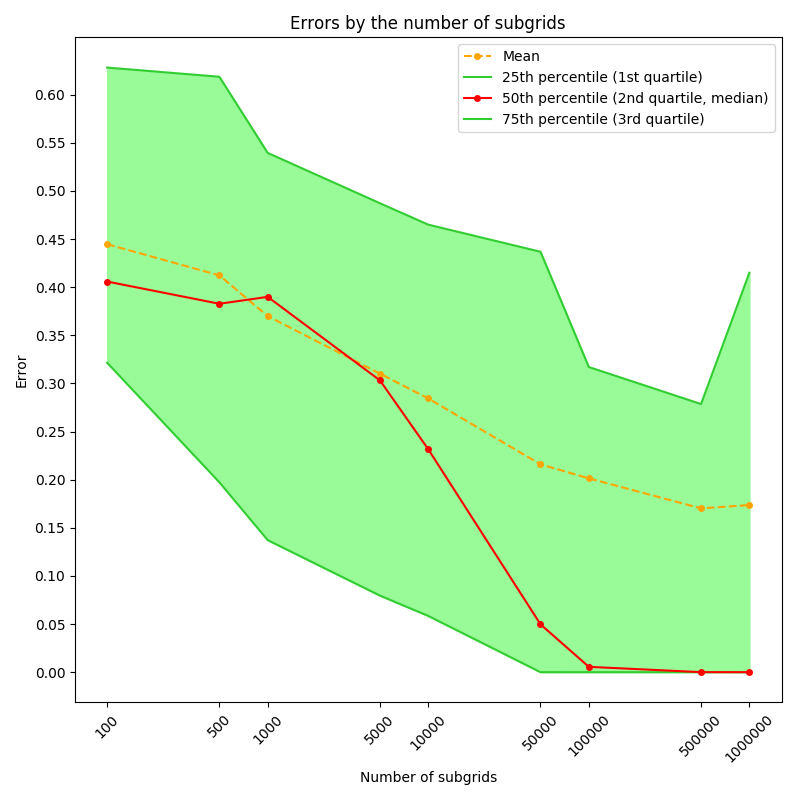

In [23]:
# Line plot of errors by the number of subgrids.

fig = plt.figure(figsize=(8, 8))
plt.plot(num_subgrids_list, means, color=mean_color, marker='o', linestyle='dashed', markersize=4)
plt.plot(num_subgrids_list, percentiles_25, color=percentile_25_color)
plt.plot(num_subgrids_list, percentiles_50, color=median_color, marker='o', markersize=4)
plt.plot(num_subgrids_list, percentiles_75, color=percentile_75_color)
fig.axes[0].set_xscale('symlog') # Logarithmic scale.
plt.xticks(num_subgrids_list, num_subgrids_list, rotation=45)
plt.yticks(np.arange(0.0, 0.65, 0.05))
plt.title('Errors by the number of subgrids')
plt.xlabel('Number of subgrids')
plt.ylabel('Error')
plt.legend(['Mean', '25th percentile (1st quartile)', '50th percentile (2nd quartile, median)', '75th percentile (3rd quartile)'], loc='upper right')
plt.fill_between(num_subgrids_list, percentiles_25, percentiles_75, color='palegreen')
plt.tight_layout()
plt.show()
if save_fig:
    plt.savefig((plot_path + 'errors_by_num_subgrids_line_plot_log_scale.' + fig_format), format=fig_format, dpi=fig_dpi)